## Draft: exploring *accessibleAt* property for Publications in the MarketPlace Dataset 

This notebook discovers wrong URL values (if any) in the *accessibleAt* property for Publications. 



#### External libraries and function to download descriptions from the MarketPlace dataset using the API
The following two cells are used to import the external libraries used in this Notebook and to define a function; in the final release of this Notebook this function will be (possibly) optimized and provided as an external library.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def getMPDescriptions (url, pages):
    mdx = pd.Series(range(1, pages+1))
    df_desc = pd.DataFrame()
    for var in mdx:
        turl = url+str(var)+"&perpage=20"
        df_desc_par=pd.read_json(turl, orient='columns')
        df_desc=df_desc.append(df_desc_par, ignore_index=True)
        
    return (df_desc)

### 1 - Get the the descriptions of Publications
The MarketPlace API are used to download the descriptions of Publications

In [4]:
df_tool_all = pd.DataFrame()
df_tool_all =getMPDescriptions ("https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/publications?page=", 151)
df_tool_all.index

RangeIndex(start=0, stop=2986, step=1)

#### A quick look at data
The table below shows information about few, randomly chosen, descriptions.  
Only a subset of values are shown, in particular: *id, category, label, licenses, contributors, accessibleAt, sourceItemId*.  

In [10]:
df_publication_flat = pd.json_normalize(df_tool_all['publications'])
#df_publication_flat.info()
df_publication_work=df_tool_flat[['id', 'category', 'label', 'licenses', 'contributors', 'accessibleAt', 'sourceItemId']]
df_publication_work.head()

,id,category,label,licenses,contributors,accessibleAt,sourceItemId
0,24071,publication,11th Annual International Conference of the Al...,[],"[{'actor': {'id': 692, 'name': 'Maciej Eder', ...",[http://dh2016.adho.org/abstracts/],conf/dihu/2016
1,23626,publication,12th Annual International Conference of the Al...,[],"[{'actor': {'id': 1647, 'name': 'Rhian Lewis',...",[https://dh2017.adho.org/program/abstracts/],conf/dihu/2017
2,23204,publication,13th Annual International Conference of the Al...,[],"[{'actor': {'id': 3084, 'name': 'Jonathan Giró...",[https://dh2018.adho.org/en/abstracts/],conf/dihu/2018
3,23205,publication,15th Annual International Conference of the Al...,[],"[{'actor': {'id': 3085, 'name': 'Laura Estill'...",[https://dh2020.adho.org/abstracts/],conf/dihu/2020
4,23218,publication,1947Partition On The Margins - The Untold Test...,[],"[{'actor': {'id': 2181, 'name': 'Nirmala Menon...",[https://dh2017.adho.org/abstracts/081/081.pdf],conf/dihu/AroraM17


### 2 - Check values in *accessibleAT*
A dataframe with three columns: *id, label, AccessibleAt* (see table below for example) is created.

In [11]:
df_publication_work=df_publication_work[['id','label','accessibleAt']]
df_publication_work.sort_values('accessibleAt').tail()

,id,label,accessibleAt
1657,28380,Metamorfoze Preservation Imaging Guidelines,[https://www.metamorfoze.nl/sites/metamorfoze....
2741,28578,Trusted Digital Repositories: Attributes and R...,[https://www.oclc.org/content/dam/research/act...
9,11580,4 Default Text Structure - The TEI Guidelines,[https://www.tei-c.org/release/doc/tei-p5-doc/...
2462,11622,The Extensible Stylesheet Language Family (XSL),[https://www.w3.org/Style/XSL/]
2622,27804,The Value of Open Data Sharing: A CODATA Repor...,[https://zenodo.org/record/33830#.WnmipoIiEdW]


#### Check if there are empty values in *accessibleAt*

In [15]:
df_publication_work_emptyurls=df_publication_work[df_publication_work['accessibleAt'].str.len()==0]
emptyurldescriptionsn=df_publication_work_emptyurls.count()[0]
print(f'\n There are {emptyurldescriptionsn} publications descriptions without corresponding accessibleAt URLs\n')


 There are 22 publications descriptions without corresponding accessibleAt URLs



#### Check the validity of URLs in the *accessibleAt* property using the HTTP Result Status
The code below explicitly execute an http call for every URL, waits for the [Result Status Code](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes)  of the call and then registers the code.  
Depending on connections and server answer times it may take several minutes to process all URLs.  
In the final release of this Notebook this code will be (possibly) optimized and provided as an external library.

In [16]:
df_publication_work=df_publication_work.explode('accessibleAt')

In [17]:
df_publication_work_urls=df_publication_work[df_publication_work['accessibleAt'].str.len()>0]
df_urls=df_publication_work_urls['accessibleAt'].values
df_publication_work_aa_http_status = pd.DataFrame (columns = ['url','status'])
import requests
import re
regex = re.compile(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' #domain...
        r'localhost|' #localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
        r'(?::\d+)?' # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)
for var in df_urls:
    if ( var != "" and var!=None and re.match(regex, var)):
        try:
            r =requests.get(var,timeout=8)
            df_publication_work_aa_http_status = df_publication_work_aa_http_status.append({'url': var, 'status': int(r.status_code)}, ignore_index=True)
        except requests.exceptions.ConnectionError:
          #  print(var)
            df_publication_work_aa_http_status = df_publication_work_aa_http_status.append({'url': var, 'status': int(503)}, ignore_index=True)
        except requests.exceptions.ConnectTimeout:
          #  print(var)
            df_publication_work_aa_http_status = df_publication_work_aa_http_status.append({'url': var, 'status': int(408)}, ignore_index=True)
        except requests.exceptions.ReadTimeout:
         #   print(var)
            df_publication_work_aa_http_status = df_publication_work_aa_http_status.append({'url': var, 'status': int(408)}, ignore_index=True)
        except requests.exceptions.RequestException:
         #   print(var)
            df_publication_work_aa_http_status = df_publication_work_aa_http_status.append({'url': var, 'status': int(500)}, ignore_index=True)
        except TypeError:
        #    print(var)
            df_publication_work_aa_http_status = df_publication_work_aa_http_status.append({'url': var, 'status': int(400)}, ignore_index=True)
    else:
       # print(var ,0)
        df_publication_work_aa_http_status = df_publication_work_aa_http_status.append({'url': var, 'status': int(400)}, ignore_index=True)
#df_publication_work_aa_http_status.head()

In [18]:
df_publication_work_aa_http_status.head()

,url,status
0,http://dh2016.adho.org/abstracts/,200
1,https://dh2017.adho.org/program/abstracts/,404
2,https://dh2018.adho.org/en/abstracts/,200
3,https://dh2020.adho.org/abstracts/,200
4,https://dh2017.adho.org/abstracts/081/081.pdf,200


In [20]:
df_http_status_sub=df_publication_work_aa_http_status[df_publication_work_aa_http_status['status'] != 1]
df_db_st = df_http_status_sub['status'].value_counts()
print('{:<8}Frequency'.format("Status"))
df_db_st.head(10)

Status  Frequency


200    2688
404     219
403      43
503      11
500       1
408       1
405       1
Name: status, dtype: int64

The first column in the table above shows the HTTP Status codes obtained when trying to connect on *accessibleAt* URLs, the second column the total number of URLs returning the status.
Notice that while 404 means that the resource is not found, other status codes may indicate temporary problems.  
The image below summarizes of the above result.

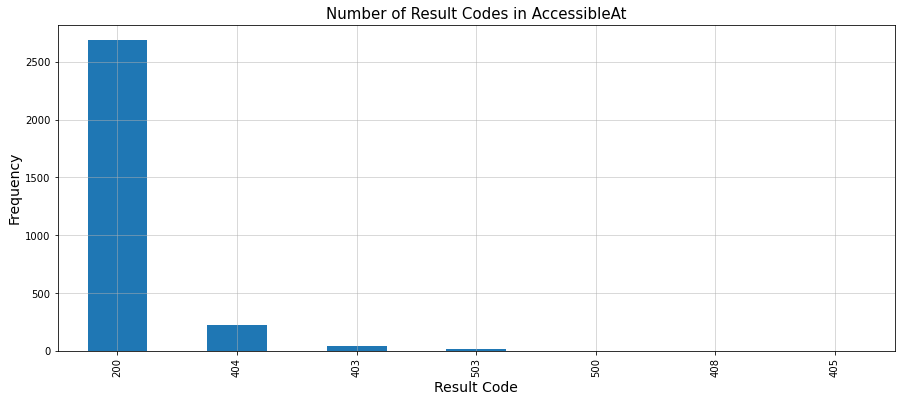

In [21]:
fig, ax = plt.subplots()
df_db_st.plot(kind='bar', figsize=(15,6), x='Status', y='Frequency',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of Result Codes in AccessibleAt", fontsize=15)
ax.set_xlabel('Result Code', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14);
plt.show()

### 3 - Save results
The list of possibly wrong URLs is saved in a Comma Separated Values (CSV) file having the following columns: *id, label, url, status*. The final release of this notebook will save this data in the curation dataset.

In [24]:
df_http_status_err=df_http_status_sub[df_http_status_sub['status'] != 200]
df_list_of_publication_wrongaa=pd.merge(left=df_publication_work, right=df_http_status_err, left_on='accessibleAt', right_on='url')
df_list_of_publication_wrongaa.head()
df_list_of_publication_wrongaa[['id', 'label', 'url', 'status']].sort_values('id').to_csv(path_or_buf='publication_wrongurls.csv')